In [1]:
import numpy as np 
import pandas as pd 
from pandas import DataFrame 

import matplotlib.pyplot as plt 
import seaborn as sns
import itertools
%matplotlib inline
from matplotlib.pyplot import figure
import matplotlib as mpl
import matplotlib.font_manager as fm
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'Malgun Gothic' 
plt.rcParams["font.size"] = 10
%matplotlib inline 


from datetime import datetime, timedelta 
from statsmodels.tsa.arima_model import ARIMA 

from sklearn.preprocessing import StandardScaler
# import os

In [2]:
test = pd.read_csv("data/test.csv", sep = ",")
train = pd.read_csv("data/train.csv", sep =",")
submission = pd.read_csv("data/submission.csv")

## Clustering by Ratio(미터ID마다 시간별 값/lag(1일, 7일))

In [17]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster

In [18]:
train2 = train.copy()
train2.reset_index(level=0, inplace=True)
v = train2.columns[1:12]
train3 = pd.melt(train2, id_vars=['Time'], value_vars=train2.columns[1:1292])

In [19]:
train4 = train3.groupby(['Time','variable'])['value'].agg({'value':'mean'}).reset_index()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [20]:
train5 = train4.copy()
train5['lag1'] = train5.groupby(['variable'])['value'].shift(1)
train5['lag7'] = train5.groupby(['variable'])['value'].shift(7)
train5 = train5.fillna(0)
train5['ratio1'] = train5['value']/(train5['lag1']+1)
train5['ratio7'] = train5['value']/(train5['lag7']+1)
train5.head(2)

Time variable  value  lag1  lag7  ratio1  ratio7
0  2018-02-15 00:00:00     X100  0.793   0.0   0.0   0.793   0.793
1  2018-02-15 00:00:00    X1000  0.226   0.0   0.0   0.226   0.226

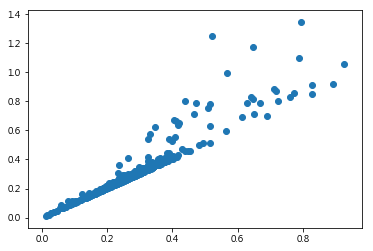

In [27]:
train6 = train5.groupby(['variable']).agg({'ratio1':'mean','ratio7':'mean'}).reset_index()
featureTr = train6.copy()
plt.scatter(featureTr['ratio1'], featureTr['ratio7'])

In [28]:
featureTr['id'] = [int(s[1:]) for s in featureTr['variable']]
featureTr2 = featureTr.iloc[:, 1:]
featureTr2

ratio1    ratio7    id
0     0.389896  0.542031   100
1     0.325501  0.347772  1000
2     0.389982  0.442093  1001
3     0.285310  0.299337  1002
4     0.259807  0.276981  1003
5     0.245632  0.254742  1004
6     0.311146  0.332397  1005
7     0.167652  0.175221  1006
8     0.210551  0.216589  1007
9     0.254806  0.283713  1008
10    0.302267  0.317933  1009
11    0.325585  0.542242   101
12    0.291339  0.299233  1010
13    0.319439  0.325492  1011
14    0.268724  0.285809  1012
15    0.310018  0.330199  1013
16    0.250192  0.267090  1014
17    0.234904  0.249394  1015
18    0.317412  0.341248  1016
19    0.249915  0.264890  1017
20    0.259501  0.277356  1018
21    0.363944  0.372385  1019
22    0.269758  0.278784  1020
23    0.292624  0.305385  1021
24    0.270765  0.277368  1022
25    0.229290  0.237064  1023
26    0.272117  0.285909  1024
27    0.316294  0.325328  1025
28    0.221843  0.231271  1026
29    0.312840  0.328359  1027
...        ...       ...   ...
1261  0.373694  0.402236   972
1262  0.206496  0.220832   973
1263  0.388876  0.412415   974
1264  0.201258  0.205316   975
1265  0.223918  0.228761   976
1266  0.317911  0.333649   977
1267  0.369155  0.393678   978
1268  0.280629  0.293904   979
1269  0.398913  0.526267    98
1270  0.305643  0.324461   980
1271  0.122515  0.130698   981
1272  0.316981  0.333091   982
1273  0.242524  0.251593   983
1274  0.344679  0.357216   984
1275  0.270866  0.291135   985
1276  0.342080  0.360848   986
1277  0.268041  0.278909   987
1278  0.305650  0.327249   988
1279  0.284227  0.298231   989
1280  0.234930  0.267937    99
1281  0.269315  0.277635   990
1282  0.371656  0.389600   991
1283  0.323045  0.333421   992
1284  0.328602  0.336454   993
1285  0.311010  0.326494   994
1286  0.405583  0.419062   995
1287  0.254699  0.264539   996
1288  0.329498  0.345021   997
1289  0.359359  0.386620   998
1290  0.340037  0.349079   999

[1291 rows x 3 columns]

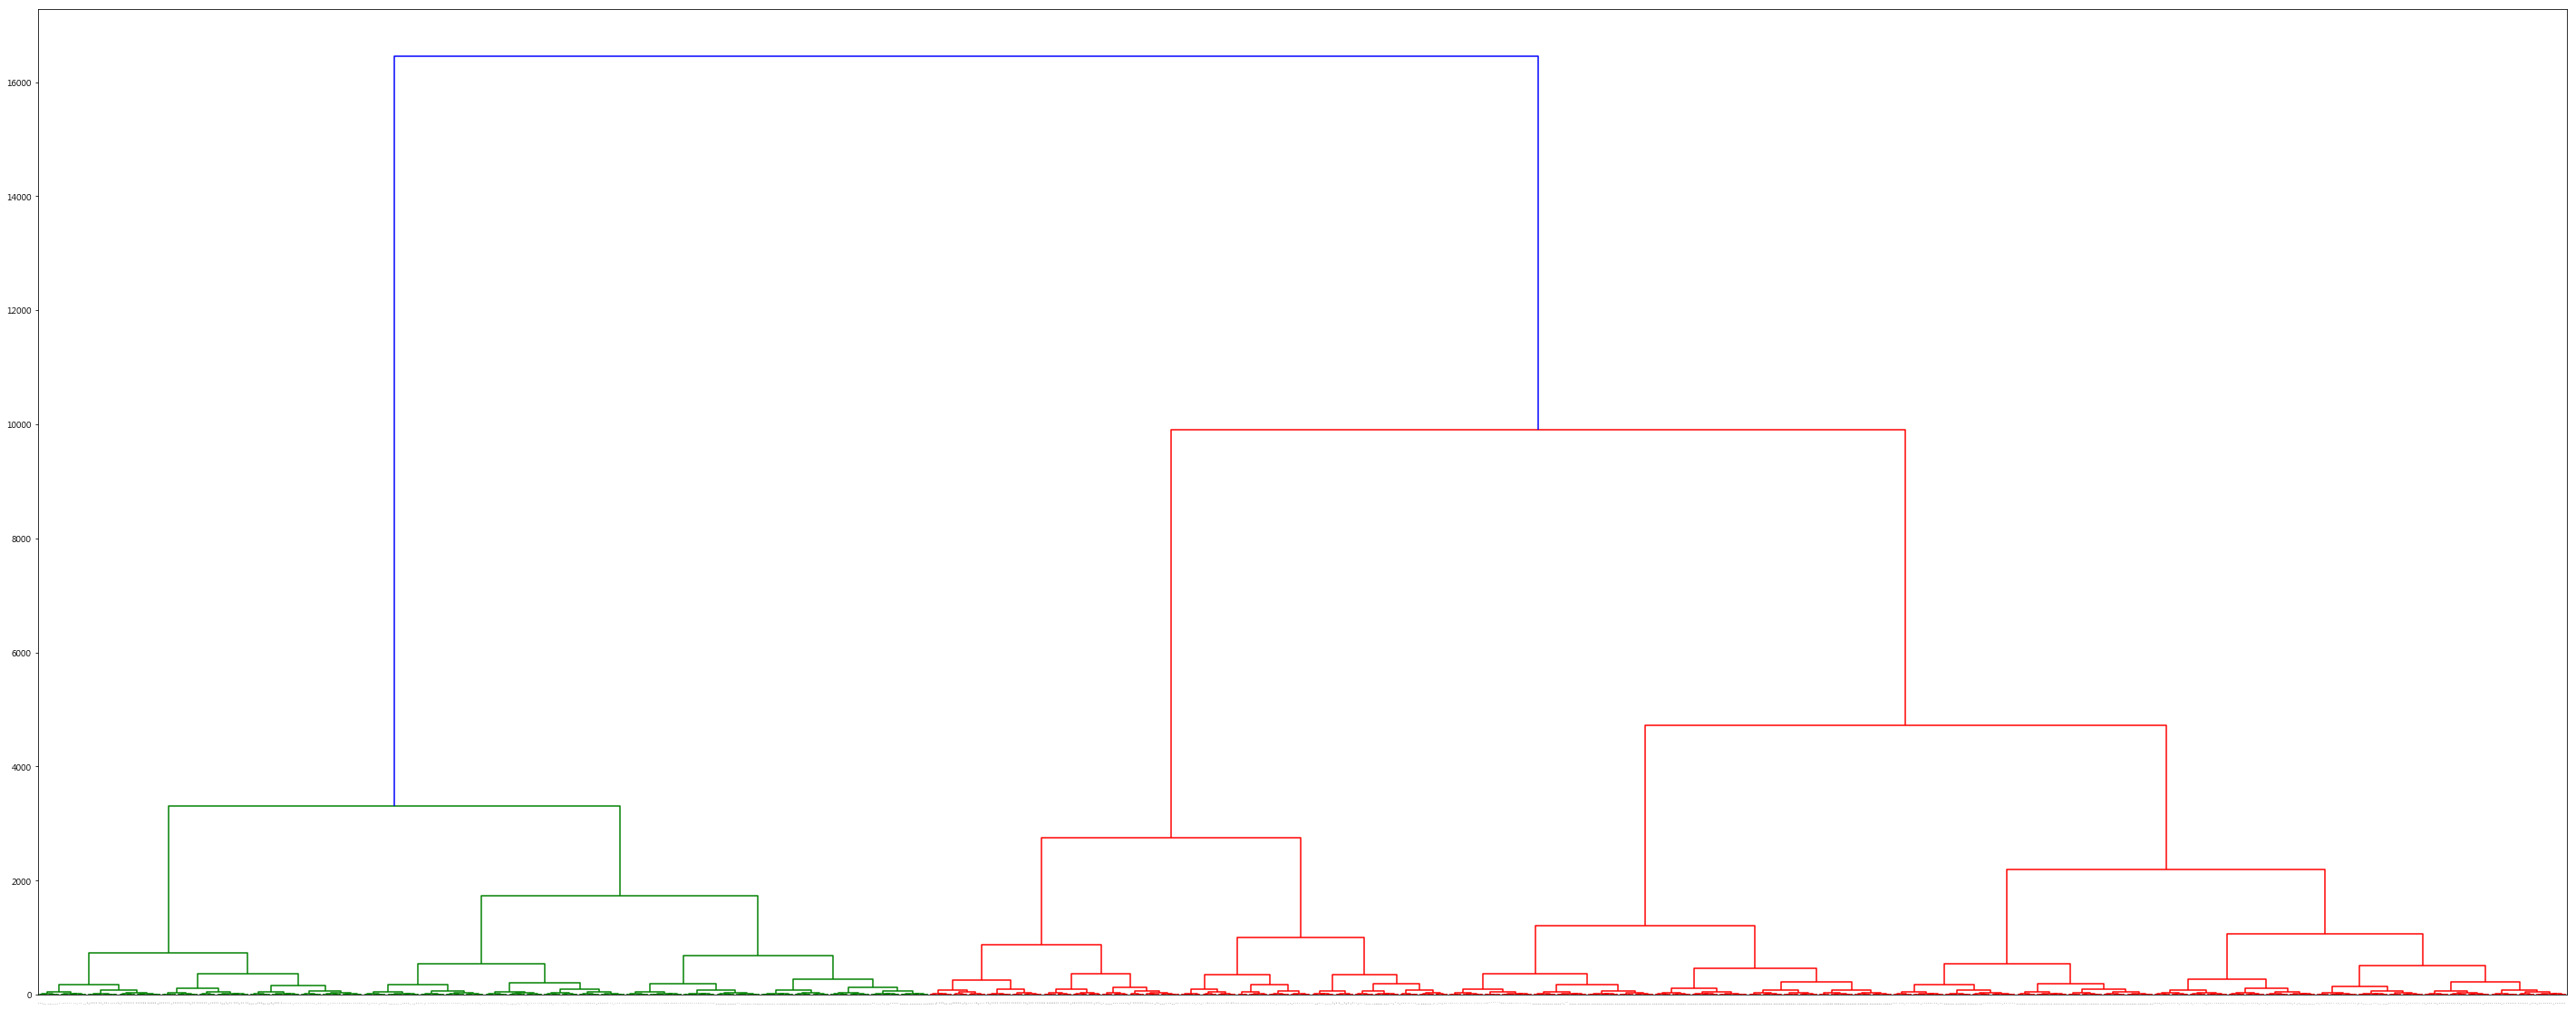

In [29]:
Z = linkage(featureTr2,'ward')

plt.figure(figsize=(50,20))
dendrogram(Z,
           leaf_rotation=100,
           leaf_font_size=1,
)
plt.show()

In [30]:
k=3
featureTr3 = featureTr.copy()
featureTr3 = featureTr3.drop(columns='id')
predict = fcluster(Z, k, criterion = 'maxclust')
featureTr3['cluster']=predict
train7 = pd.merge(train5, featureTr3, on ='variable',how='left')

c_1T = train7[train7['cluster']==1]
c_2T = train7[train7['cluster']==2]
c_3T = train7[train7['cluster']==3]

In [31]:
cnt_srs_1T = c_1T.groupby('Time')['value'].mean()
cnt_srs_2T = c_2T.groupby('Time')['value'].mean()
cnt_srs_3T = c_3T.groupby('Time')['value'].mean()

In [32]:
import plotly.graph_objs as go
def scatter_plot(cnt_srs, color, showlegend1=False, name1 = ""):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        name = name1,
        showlegend=showlegend1,
        marker=dict(
            color=color,
        ),
    )
    return trace

In [33]:
trace_1T = scatter_plot(cnt_srs_1T, 'yellow', True ,'Cluster_1')
trace_2T = scatter_plot(cnt_srs_2T, 'green', True ,'Cluster_2')
trace_3T = scatter_plot(cnt_srs_3T, 'red', True ,'Cluster_3')

In [34]:
import plotly.offline as py
layout = go.Layout(
    height=500,
    width=1000,
    #paper_bgcolor='rgb(233,233,233)',
    title='Train Clustering_3'
)

data = [trace_1T,trace_2T, trace_3T]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="ActivationDate")

In [37]:
test2 = test.copy()

In [38]:
test2.reset_index(level=0, inplace=True)
v = test2.columns[1:12]
test3 = pd.melt(test2, id_vars=['Time'], value_vars=test2.columns[1:1292])

In [39]:
test4 = test3.groupby(['Time','variable'])['value'].agg({'value':'mean'}).reset_index()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version



In [40]:
test5 = test4.copy()
test5['lag1'] = test5.groupby(['variable'])['value'].shift(1)
test5['lag7'] = test5.groupby(['variable'])['value'].shift(7)
test5 = test5.fillna(0)
test5['ratio1'] = test5['value']/(test5['lag1']+1)
test5['ratio7'] = test5['value']/(test5['lag7']+1)
test5.head(2)

Time variable     value  lag1  lag7    ratio1    ratio7
0  2017-08-29 10:00:00      X10  3.042443   0.0   0.0  3.042443  3.042443
1  2017-08-29 10:00:00     X102  0.806000   0.0   0.0  0.806000  0.806000

In [41]:
test6 = test5.groupby(['variable']).agg({'ratio1':'mean','ratio7':'mean'}).reset_index()
feature = test6
plt.scatter(feature['ratio1'], feature['ratio7'])

In [42]:
feature['id'] = [int(s[1:]) for s in feature['variable']]
feature2 = feature.iloc[:, 1:]
feature2

ratio1    ratio7   id
0    0.748881  0.781495   10
1    0.469327  0.807009  102
2    0.351904  0.665737  105
3    0.400738  0.447330  106
4    0.220319  0.385870  107
5    0.351174  0.483736  110
6    0.271874  0.325006  111
7    0.377484  0.690035  116
8    0.443285  0.735217  120
9    0.432406  0.698408  123
10   0.460613  0.829722  124
11   0.474409  0.812337  125
12   0.120700  0.178562  126
13   0.300246  0.312027  130
14   0.272006  0.283098  132
15   0.234149  0.248029  133
16   0.234557  0.247504  134
17   0.272655  0.285822  139
18   0.276972  0.289315  140
19   0.319799  0.344226  142
20   0.165592  0.169774  143
21   0.214042  0.226299  148
22   0.244777  0.252688  149
23   0.225592  0.237707  155
24   0.193097  0.200337  157
25   0.208627  0.219264  158
26   0.792509  0.811510   16
27   0.225987  0.227574  160
28   0.311622  0.326569  161
29   0.233343  0.242390  163
..        ...       ...  ...
170  0.201018  0.208659  457
171  0.137633  0.141454  459
172  0.130994  0.133862  460
173  0.184478  0.190819  462
174  0.179362  0.187128  468
175  0.081127  0.084720   47
176  0.270500  0.272789  470
177  0.202279  0.209352  472
178  0.149158  0.151985  473
179  0.201793  0.203770  481
180  0.862000  0.867240    5
181  0.788303  0.895604   50
182  0.948552  1.007288   51
183  0.908699  1.308905   55
184  0.668905  0.858148   59
185  0.703105  0.771494   61
186  0.221047  0.227880   62
187  0.425134  0.528830   67
188  0.743961  1.071526   68
189  0.575984  0.588086    7
190  0.401959  0.747664   70
191  0.050170  0.062077   73
192  0.501131  0.776961   75
193  0.311457  0.560970   76
194  0.874101  1.789482   80
195  0.418714  0.608160   82
196  0.602111  1.131949   87
197  0.311115  0.523360   88
198  0.411087  0.713258   91
199  0.105985  0.133872   94

[200 rows x 3 columns]

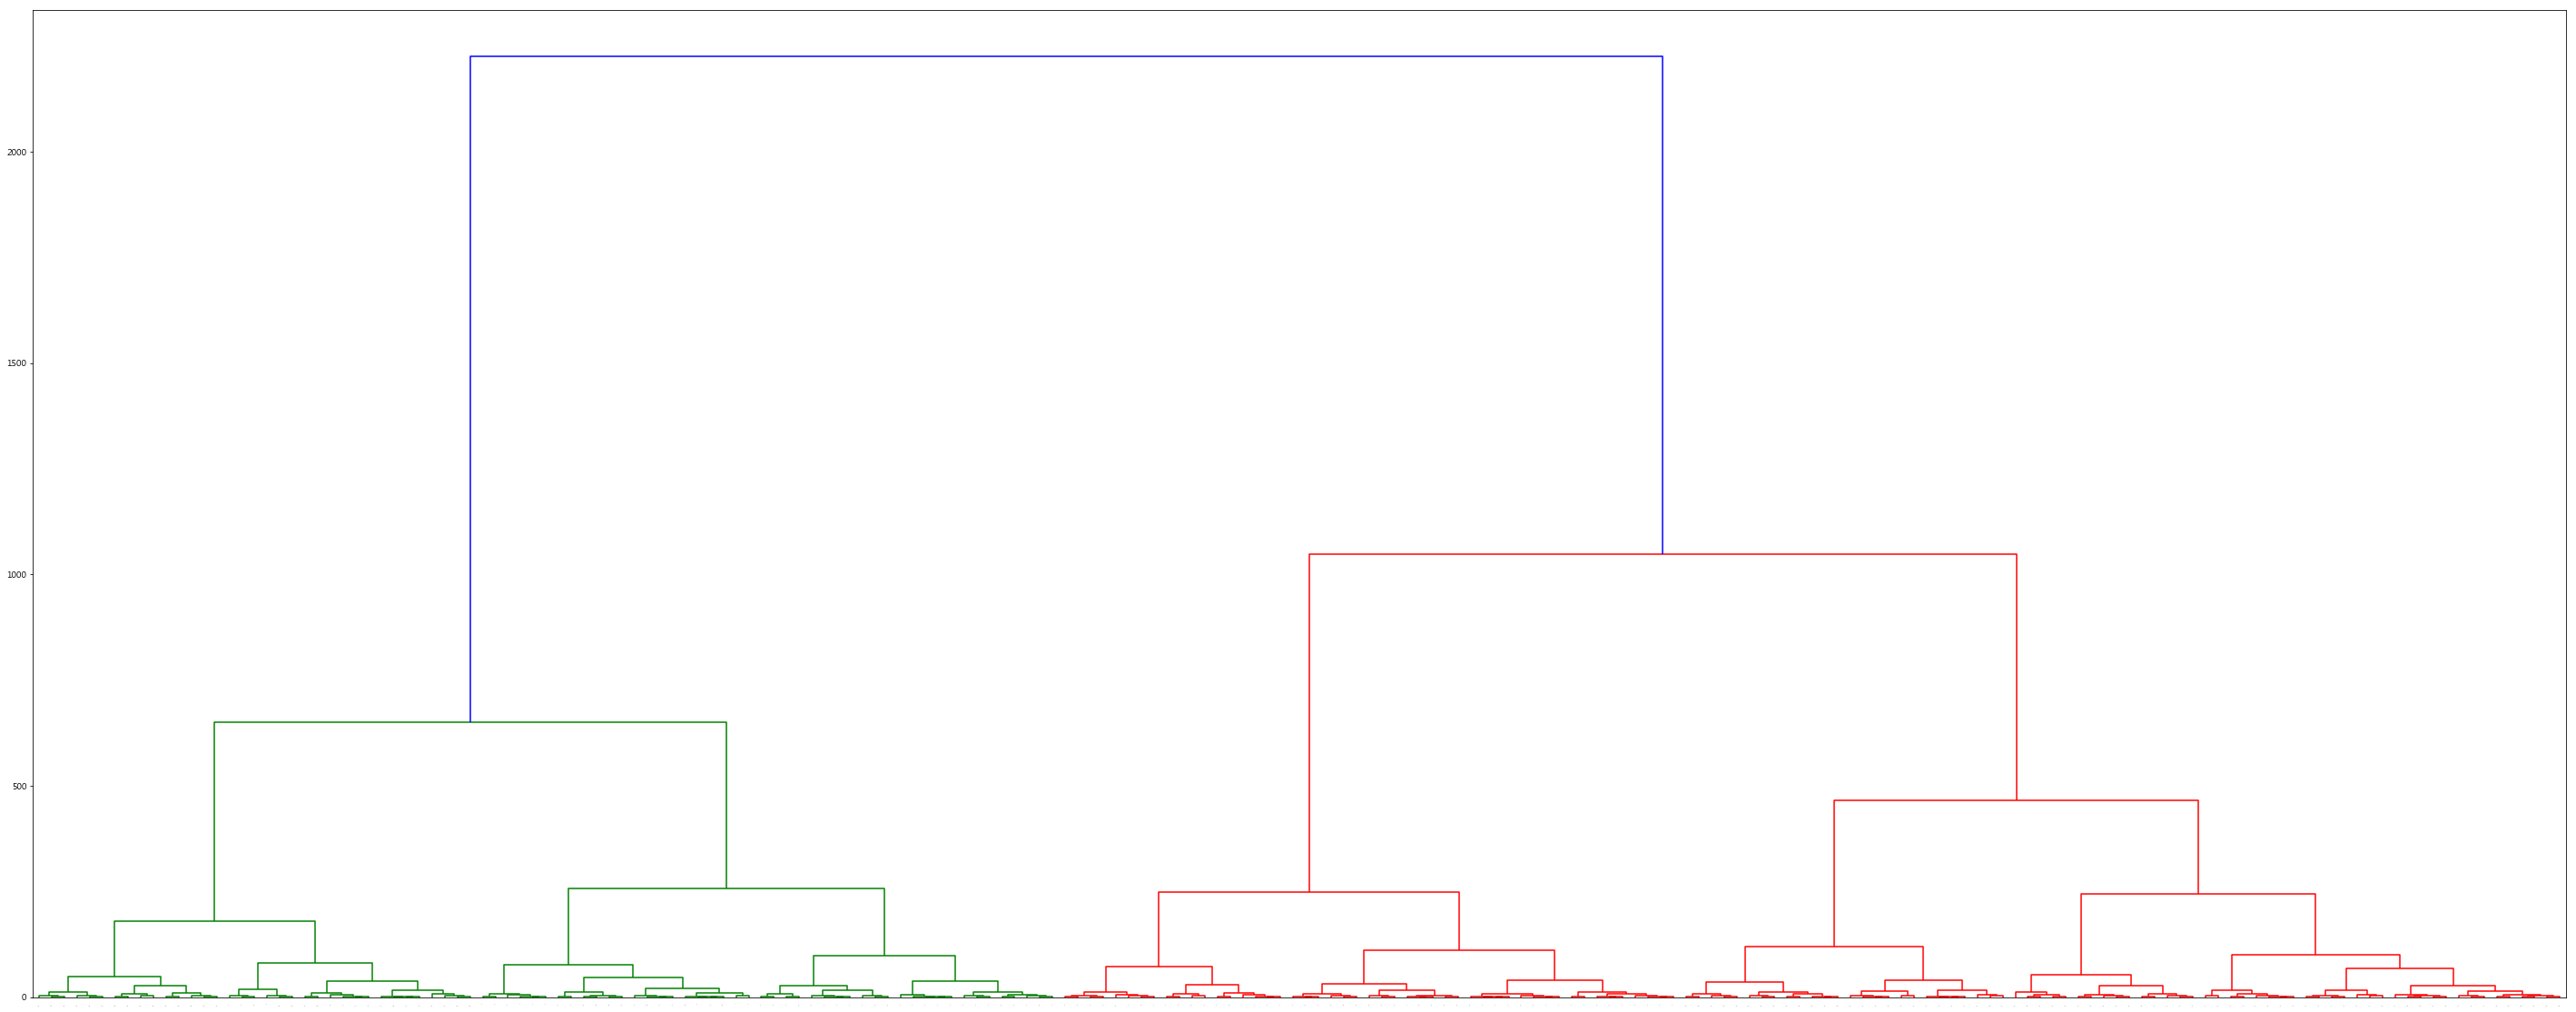

In [43]:
Z = linkage(feature2,'ward')

plt.figure(figsize=(50,20))
dendrogram(Z,
           leaf_rotation=100,
           leaf_font_size=1,
)
plt.show()

In [46]:
feature3 = feature.copy()
feature3 = feature3.drop(columns='id')

In [47]:
k=3

predict = fcluster(Z, k, criterion = 'maxclust')
feature3['cluster']=predict
test7 = pd.merge(test5, feature3, on ='variable',how='left')

c_1 = test7[test7['cluster']==1]
c_2 = test7[test7['cluster']==2]
c_3 = test7[test7['cluster']==3]
# c_4 = test7[test7['cluster']==4]

In [48]:
cnt_srs_1 = c_1.groupby('Time')['value'].mean()
cnt_srs_2 = c_2.groupby('Time')['value'].mean()
cnt_srs_3 = c_3.groupby('Time')['value'].mean()
# cnt_srs_4 = c_4.groupby('Time')['value'].mean()

In [49]:
import plotly.graph_objs as go
def scatter_plot(cnt_srs, color, showlegend1=False, name1 = ""):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        name = name1,
        showlegend=showlegend1,
        marker=dict(
            color=color,
        ),
    )
    return trace

In [50]:
trace_1 = scatter_plot(cnt_srs_1, 'yellow', True ,'Cluster_1')
trace_2 = scatter_plot(cnt_srs_2, 'green', True ,'Cluster_2')
trace_3 = scatter_plot(cnt_srs_3, 'red', True ,'Cluster_3')
# trace_4 = scatter_plot(cnt_srs_3, 'grey', True ,'Cluster_3')

In [51]:
import plotly.offline as py
layout = go.Layout(
    height=500,
    width=1000,
    #paper_bgcolor='rgb(233,233,233)',
    title='Test Clustering_2'
)

data = [trace_1,trace_2, trace_3]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="ActivationDate")

In [52]:
test7.groupby('cluster')['variable'].nunique()

cluster
1    81
2    49
3    70
Name: variable, dtype: int64

In [53]:
# TEST에서 각각의 클러스터에 해당하는 ID 추출
c1_testID = np.unique(test7[test7.cluster==1]['variable'])
c2_testID = np.unique(test7[test7.cluster==2]['variable'])
c3_testID = np.unique(test7[test7.cluster==3]['variable'])

In [54]:
print(c1_testID,'\n',c2_testID,'\n', c3_testID)

['X10' 'X102' 'X105' 'X106' 'X107' 'X110' 'X111' 'X116' 'X120' 'X123'
 'X124' 'X125' 'X126' 'X130' 'X132' 'X133' 'X134' 'X139' 'X140' 'X142'
 'X143' 'X148' 'X149' 'X155' 'X157' 'X158' 'X16' 'X160' 'X161' 'X163'
 'X165' 'X166' 'X172' 'X175' 'X176' 'X177' 'X178' 'X18' 'X183' 'X186'
 'X187' 'X192' 'X194' 'X195' 'X196' 'X20' 'X200' 'X201' 'X205' 'X206'
 'X26' 'X30' 'X31' 'X32' 'X35' 'X37' 'X41' 'X42' 'X43' 'X44' 'X47' 'X5'
 'X50' 'X51' 'X55' 'X59' 'X61' 'X62' 'X67' 'X68' 'X7' 'X70' 'X73' 'X75'
 'X76' 'X80' 'X82' 'X87' 'X88' 'X91' 'X94'] 
 ['X211' 'X213' 'X214' 'X215' 'X216' 'X217' 'X218' 'X219' 'X223' 'X225'
 'X228' 'X229' 'X230' 'X231' 'X232' 'X233' 'X235' 'X241' 'X242' 'X243'
 'X245' 'X247' 'X248' 'X250' 'X252' 'X253' 'X254' 'X255' 'X260' 'X262'
 'X263' 'X266' 'X269' 'X270' 'X271' 'X275' 'X276' 'X282' 'X283' 'X286'
 'X289' 'X296' 'X297' 'X299' 'X300' 'X302' 'X303' 'X305' 'X308'] 
 ['X312' 'X313' 'X314' 'X315' 'X320' 'X323' 'X326' 'X329' 'X330' 'X331'
 'X333' 'X337' 'X341' 'X347' 'X349' '

## NA 채우기
- 요일+시간가중치+Dacon적용, 누적값 분산한 ch_Test, ch_Train을 각각 50% 이상의 데이터가 존재하는 시간대에서 cut
- Train (X118) 데이터 값이 1개여서 추가 drop
- Arima를 이용해 단순 예측한 24hr을 시간에 맞춰 대입

In [333]:
changed_train = pd.read_csv("data/train_DHWeight_onDacon.csv", index_col=0, sep=',')
changed_test = pd.read_csv("data/test_DHWeight_onDacon.csv", index_col=0, sep=',')

In [387]:
changed_test.shape

(8760, 200)

In [334]:
changed_test.index = pd.to_datetime(changed_test.index) 
changed_train.index = pd.to_datetime(changed_train.index) 

In [394]:
idx = changed_test.count(axis = 'columns') >= 200*0.5
ch_te_TimeCut = changed_test[changed_test[idx].index[0]:]

In [395]:
arima_test = pd.read_csv("data/TEST_DHWonDacon_24시간예측.csv",index_col=0, sep=',')
arima_train = pd.read_csv("data/TRAIN_DHWonDacon_24시간예측.csv",index_col=0, sep=',')

In [402]:
def fillNA(df1, df2):
    df = pd.DataFrame()
    n=0
    for i in df1.columns:
        n += 1
        li = df1[df1[i].isnull()].index
        tmp = pd.DataFrame(df1[i]) 
        print("%d. current column: %s, NaN count: %d" %(n, i, len(li)))
        for time in li:
            h = time.hour
            tmp.loc[time] = df2.iloc[h][i]
        df = pd.concat([df,tmp], axis=1) 
    return df

In [403]:
TE_TimeCut_NAfilled = fillNA(ch_te_TimeCut, arima_test)
TE_TimeCut_NAfilled.shape

1. current column: X26, NaN count: 5577
2. current column: X303, NaN count: 221
3. current column: X241, NaN count: 358
4. current column: X435, NaN count: 316
5. current column: X402, NaN count: 311
6. current column: X352, NaN count: 260
7. current column: X305, NaN count: 305
8. current column: X350, NaN count: 253
9. current column: X326, NaN count: 381
10. current column: X299, NaN count: 326
11. current column: X160, NaN count: 481
12. current column: X125, NaN count: 0
13. current column: X211, NaN count: 381
14. current column: X349, NaN count: 152
15. current column: X407, NaN count: 333
16. current column: X330, NaN count: 277
17. current column: X132, NaN count: 338
18. current column: X231, NaN count: 508
19. current column: X225, NaN count: 463
20. current column: X16, NaN count: 5577
21. current column: X286, NaN count: 404
22. current column: X354, NaN count: 295
23. current column: X353, NaN count: 319
24. current column: X76, NaN count: 0
25. current column: X255, NaN 

(7334, 200)

In [404]:
ch_te_TimeCut.iloc[:,ch_te_TimeCut.isnull().sum().values == 5577].columns

Index(['X26', 'X16', 'X7', 'X18', 'X41', 'X55', 'X5', 'X43', 'X59', 'X10',
       'X62', 'X61', 'X32', 'X31', 'X30', 'X51', 'X35', 'X44', 'X37', 'X42',
       'X50', 'X47', 'X20'],
      dtype='object')

In [405]:
idx = changed_train.count(axis = 'columns') >= 1292*0.5
ch_tr_TimeCut = changed_train[changed_train[idx].index[0]:]
ch_tr_TimeCut

X692     X1272      X553     X1299      X598  \
Time                                                                    
2018-02-15 00:00:00  0.150000  0.392000  0.181000  0.237000  0.064000   
2018-02-15 01:00:00  0.422000  0.873000  0.502000  0.356000  0.160000   
2018-02-15 02:00:00  0.314000  0.440000  0.461000  0.308000  0.174000   
2018-02-15 03:00:00  0.309000  0.292000  0.524000  0.279000  0.198000   
2018-02-15 04:00:00  0.327000  0.298000  0.486000  0.364000  0.155000   
2018-02-15 05:00:00  0.303000  0.254000  0.514000  0.953000  0.198000   
2018-02-15 06:00:00  0.273000  0.290000  0.486000  0.547000  0.153000   
2018-02-15 07:00:00  0.798000  0.377000  0.506000  0.538000  0.222000   
2018-02-15 08:00:00  0.497000  0.247000  0.721000  0.529000  0.277000   
2018-02-15 09:00:00  0.428000  0.272000  0.397000  0.595000  0.381000   
2018-02-15 10:00:00  0.357000  0.257000  0.440000  0.492000  0.461000   
2018-02-15 11:00:00  0.387000  0.276000  0.426000  0.532000  0.265000   
2018-02-15 12:00:00  0.360000  0.277000  0.477000  0.351000  0.293000   
2018-02-15 13:00:00  0.333000  0.281000  0.432000  0.335000  0.255000   
2018-02-15 14:00:00  0.350000  0.257000  0.468000  0.298000  0.443000   
2018-02-15 15:00:00  0.751000  0.262000  0.427000  0.295000  0.462000   
2018-02-15 16:00:00  1.499000  0.260000  0.438000  0.278000  0.348000   
2018-02-15 17:00:00  1.339000  0.241000  0.414000  0.328000  0.192000   
2018-02-15 18:00:00  1.241000  0.267000  0.588000  0.277000  0.146000   
2018-02-15 19:00:00  0.741000  0.253000  0.708000  0.359000  0.138000   
2018-02-15 20:00:00  0.226000  0.088000  0.313000  0.234000  0.062000   
2018-02-15 21:00:00  0.470000  0.250000  0.779000  0.591000  0.131000   
2018-02-15 22:00:00  0.188429  0.179294  0.342936  0.267831  0.150000   
2018-02-15 23:00:00  0.178571  0.168706  0.292064  0.247169       NaN   
2018-02-16 00:00:00  0.156000  0.118000  0.189000  0.153000  0.188000   
2018-02-16 01:00:00  0.317000  0.264000  0.536000  0.381000  0.271000   
2018-02-16 02:00:00  0.298000  0.323000  0.407000  0.381000  0.251000   
2018-02-16 03:00:00  0.335000  0.265000  0.488000  0.193000  0.258000   
2018-02-16 04:00:00  0.356000  0.256000  0.412000  0.165000  0.164000   
2018-02-16 05:00:00  0.308000  0.302000  0.419000  0.175000  0.169000   
...                       ...       ...       ...       ...       ...   
2018-06-29 18:00:00  0.695084  0.472460  0.440237  0.249735  0.219088   
2018-06-29 19:00:00  0.566281  0.497203  0.447120  0.301969  0.292146   
2018-06-29 20:00:00  0.526650  0.655895  0.546455  0.249937  0.362461   
2018-06-29 21:00:00  0.484126  0.720735  0.618977  0.301550  0.409726   
2018-06-29 22:00:00  0.412224  0.736370  0.623567  0.332513  0.405812   
2018-06-29 23:00:00  0.084000  0.187000  0.123000  0.134000  0.119000   
2018-06-30 00:00:00       NaN       NaN       NaN       NaN       NaN   
2018-06-30 01:00:00       NaN       NaN       NaN       NaN       NaN   
2018-06-30 02:00:00  0.113000  0.226000  0.248000  0.080000  0.161000   
2018-06-30 03:00:00  0.264000  0.443000  0.428000  0.160000  0.283000   
2018-06-30 04:00:00  0.251000  0.445000  0.451000  0.167000  0.192000   
2018-06-30 05:00:00  0.244000  0.383000  0.345000  0.156000  0.151000   
2018-06-30 06:00:00  0.294000  0.347000  0.395000  0.152000  0.178000   
2018-06-30 07:00:00  0.392000  0.420000  0.566000  0.131000  0.160000   
2018-06-30 08:00:00  0.327000  0.414000  0.504000  0.145000  0.212000   
2018-06-30 09:00:00  0.339000  0.449000  0.510000  0.137000  0.437000   
2018-06-30 10:00:00  0.253000  0.510000  0.513000  0.142000  0.495000   
2018-06-30 11:00:00  0.369000  0.696000  0.477000  0.180000  0.342000   
2018-06-30 12:00:00  0.541000  0.749000  0.593000  0.162000  0.392000   
2018-06-30 13:00:00  0.371000  0.708000  0.426000  0.154000  0.404000   
2018-06-30 14:00:00  0.275000  0.688000  0.450000  0.159000  0.351000   
2018-06-30 15:00:00  0.328000  0.484000  0.454000  0.180000  0.445000   
2018-06-30

In [406]:
# drop a columns X118 since it is Empty in Arima_Train df
ch_tr_TimeCut = ch_tr_TimeCut.drop(columns = 'X118')

In [409]:
TR_TimeCut_NAfilled = fillNA(ch_tr_TimeCut, arima_train)
TR_TimeCut_NAfilled.shape

1. current column: X692, NaN count: 130
2. current column: X1272, NaN count: 119
3. current column: X553, NaN count: 151
4. current column: X1299, NaN count: 163
5. current column: X598, NaN count: 144
6. current column: X1003, NaN count: 232
7. current column: X1010, NaN count: 131
8. current column: X1216, NaN count: 126
9. current column: X1047, NaN count: 121
10. current column: X381, NaN count: 117
11. current column: X466, NaN count: 147
12. current column: X1420, NaN count: 125
13. current column: X686, NaN count: 116
14. current column: X711, NaN count: 115
15. current column: X1251, NaN count: 119
16. current column: X828, NaN count: 121
17. current column: X1350, NaN count: 152
18. current column: X1066, NaN count: 123
19. current column: X1293, NaN count: 152
20. current column: X1148, NaN count: 147
21. current column: X451, NaN count: 143
22. current column: X174, NaN count: 147
23. current column: X74, NaN count: 2700
24. current column: X626, NaN count: 118
25. current c

201. current column: X886, NaN count: 367
202. current column: X593, NaN count: 113
203. current column: X1121, NaN count: 144
204. current column: X1171, NaN count: 138
205. current column: X888, NaN count: 362
206. current column: X1332, NaN count: 149
207. current column: X690, NaN count: 120
208. current column: X1087, NaN count: 123
209. current column: X1213, NaN count: 117
210. current column: X665, NaN count: 118
211. current column: X795, NaN count: 120
212. current column: X430, NaN count: 96
213. current column: X484, NaN count: 143
214. current column: X114, NaN count: 0
215. current column: X1296, NaN count: 189
216. current column: X843, NaN count: 131
217. current column: X280, NaN count: 143
218. current column: X1158, NaN count: 150
219. current column: X1090, NaN count: 118
220. current column: X355, NaN count: 123
221. current column: X290, NaN count: 148
222. current column: X930, NaN count: 366
223. current column: X978, NaN count: 126
224. current column: X961, Na

397. current column: X927, NaN count: 330
398. current column: X1402, NaN count: 192
399. current column: X1400, NaN count: 150
400. current column: X1434, NaN count: 117
401. current column: X921, NaN count: 372
402. current column: X1340, NaN count: 182
403. current column: X1250, NaN count: 123
404. current column: X236, NaN count: 145
405. current column: X890, NaN count: 366
406. current column: X1202, NaN count: 175
407. current column: X1247, NaN count: 115
408. current column: X180, NaN count: 149
409. current column: X662, NaN count: 116
410. current column: X415, NaN count: 122
411. current column: X198, NaN count: 146
412. current column: X805, NaN count: 115
413. current column: X360, NaN count: 117
414. current column: X526, NaN count: 109
415. current column: X1154, NaN count: 129
416. current column: X1153, NaN count: 128
417. current column: X956, NaN count: 128
418. current column: X702, NaN count: 115
419. current column: X590, NaN count: 119
420. current column: X115

591. current column: X1219, NaN count: 450
592. current column: X1182, NaN count: 130
593. current column: X658, NaN count: 121
594. current column: X1059, NaN count: 135
595. current column: X1243, NaN count: 117
596. current column: X844, NaN count: 117
597. current column: X292, NaN count: 148
598. current column: X1410, NaN count: 119
599. current column: X1379, NaN count: 147
600. current column: X589, NaN count: 116
601. current column: X1140, NaN count: 131
602. current column: X1305, NaN count: 145
603. current column: X1359, NaN count: 146
604. current column: X684, NaN count: 116
605. current column: X999, NaN count: 133
606. current column: X871, NaN count: 365
607. current column: X829, NaN count: 128
608. current column: X1084, NaN count: 117
609. current column: X638, NaN count: 118
610. current column: X1409, NaN count: 115
611. current column: X510, NaN count: 114
612. current column: X8, NaN count: 3262
613. current column: X987, NaN count: 100
614. current column: X10

786. current column: X458, NaN count: 121
787. current column: X708, NaN count: 107
788. current column: X27, NaN count: 1507
789. current column: X867, NaN count: 116
790. current column: X777, NaN count: 115
791. current column: X145, NaN count: 147
792. current column: X1403, NaN count: 163
793. current column: X531, NaN count: 121
794. current column: X507, NaN count: 112
795. current column: X575, NaN count: 146
796. current column: X1072, NaN count: 119
797. current column: X311, NaN count: 125
798. current column: X1038, NaN count: 118
799. current column: X1013, NaN count: 141
800. current column: X863, NaN count: 127
801. current column: X199, NaN count: 146
802. current column: X503, NaN count: 127
803. current column: X301, NaN count: 82
804. current column: X319, NaN count: 120
805. current column: X1045, NaN count: 113
806. current column: X1321, NaN count: 185
807. current column: X1117, NaN count: 148
808. current column: X168, NaN count: 147
809. current column: X1172, 

983. current column: X113, NaN count: 0
984. current column: X840, NaN count: 123
985. current column: X998, NaN count: 131
986. current column: X799, NaN count: 115
987. current column: X1204, NaN count: 158
988. current column: X572, NaN count: 118
989. current column: X1174, NaN count: 170
990. current column: X807, NaN count: 127
991. current column: X1110, NaN count: 139
992. current column: X12, NaN count: 1507
993. current column: X985, NaN count: 126
994. current column: X1069, NaN count: 121
995. current column: X257, NaN count: 148
996. current column: X880, NaN count: 380
997. current column: X919, NaN count: 363
998. current column: X49, NaN count: 1507
999. current column: X1320, NaN count: 185
1000. current column: X625, NaN count: 117
1001. current column: X1149, NaN count: 143
1002. current column: X1053, NaN count: 119
1003. current column: X597, NaN count: 91
1004. current column: X304, NaN count: 124
1005. current column: X650, NaN count: 118
1006. current column: X3

1173. current column: X1268, NaN count: 119
1174. current column: X887, NaN count: 368
1175. current column: X1388, NaN count: 142
1176. current column: X640, NaN count: 117
1177. current column: X90, NaN count: 0
1178. current column: X552, NaN count: 110
1179. current column: X1173, NaN count: 134
1180. current column: X935, NaN count: 362
1181. current column: X1118, NaN count: 140
1182. current column: X434, NaN count: 122
1183. current column: X1054, NaN count: 127
1184. current column: X562, NaN count: 116
1185. current column: X693, NaN count: 121
1186. current column: X1375, NaN count: 147
1187. current column: X1289, NaN count: 166
1188. current column: X1339, NaN count: 181
1189. current column: X182, NaN count: 147
1190. current column: X1491, NaN count: 142
1191. current column: X649, NaN count: 1449
1192. current column: X511, NaN count: 112
1193. current column: X1102, NaN count: 120
1194. current column: X916, NaN count: 365
1195. current column: X184, NaN count: 147
119

(3264, 1291)

In [408]:
TE_TimeCut_NAfilled.to_csv("data/TEST_DHweightDaconArima_NAFilled.csv")

In [139]:
TR_TimeCut_NAfilled.to_csv("data/TRAIN_DHweightDaconArima_NAFilled.csv")

## Weather 추가변수
- 나중에 모델 돌릴때마다 df에 추가하는 것

In [6]:
# hourly WEATHER data
w_hr = pd.read_csv("data/weather/인천_시간별__기상자료(16-18)_축소__7월1일.csv",encoding='euc-kr', sep=',')
w_hr2 = w_hr.loc[:,['일시', '기온(°C)', '강수량(mm)', '풍속(m/s)']]
w_hr2['강수량(mm)']=w_hr2.loc[:,'강수량(mm)'].fillna(0)
old = w_hr2.columns
new = ['Time', 'Temp', 'Precipitation', 'Wind']
w_hr2 = w_hr2.rename(columns=dict(zip(old, new)))
w_hr2.head(2)

Time  Temp  Precipitation  Wind
0  2016.7.20 0:00  25.7            0.0   1.3
1  2016.7.20 1:00  25.6            0.0   1.4

In [7]:
# daily WEATHER data
w_daily = pd.read_csv("data/weather/인천_일별_기상자료(16-18)_축소.csv",encoding='euc-kr', sep=',')
w_daily2 = w_daily.iloc[:,1:5]
old = w_daily2.columns
new = ['Time', 'AvgT', 'MinT', 'MaxT']
w_daily2 = w_daily2.rename(columns=dict(zip(old, new)))
w_daily2.head(2)

Time  AvgT  MinT  MaxT
0  2016-07-20  28.1  24.6  31.6
1  2016-07-21  28.0  25.0  31.5

## 파생 및 dummy변수

In [152]:
test = pd.read_csv("data/TEST_DHweightDaconArima_NAFilled.csv", index_col=0, sep=',')
train = pd.read_csv("data/TRAIN_DHweightDaconArima_NAFilled.csv", index_col=0, sep=',')

In [153]:
test.head(1)

X26   X303   X241   X435   X402   X352   X305  \
Time                                                                      
2017-08-29 10:00:00  1.473264  0.431  0.276  0.228  0.432  0.232  0.348   

                      X350   X326   X299  ...   X283   X329   X223      X266  \
Time                                      ...                                  
2017-08-29 10:00:00  0.259  0.194  0.086  ...  0.114  0.087  0.283  0.342026   

                          X20   X443   X347    X75   X107      X230  
Time                                                                 
2017-08-29 10:00:00  1.160255  0.094  0.351  1.109  0.225  0.296678  

[1 rows x 200 columns]

In [155]:
test.index = pd.to_datetime(test.index)

In [384]:
ori_test = pd.read_csv("data/test.csv", index_col = 0)
ori_test.head()

X26  X303  X241  X435  X402  X352  X305  X350  X326  X299  ...  \
Time                                                                      ...   
2017.7.1 0:00  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2017.7.1 1:00  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2017.7.1 2:00  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2017.7.1 3:00  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2017.7.1 4:00  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

               X283  X329  X223  X266  X20  X443  X347    X75   X107  X230  
Time                                                                        
2017.7.1 0:00   NaN   NaN   NaN   NaN  NaN   NaN   NaN  0.275  0.021   NaN  
2017.7.1 1:00   NaN   NaN   NaN   NaN  NaN   NaN   NaN  0.222  0.021   NaN  
2017.7.1 2:00   NaN   NaN   NaN   NaN  NaN   NaN   NaN  0.237  0.021   NaN  
2017.7.1 3:00   NaN   NaN   NaN   NaN  NaN   NaN   NaN  0.229  0.020   NaN  
2017.7.1 4:00   NaN   NaN   NaN   NaN  NaN   NaN   NaN  0.202  0.021   NaN  

[5 rows x 200 columns]

In [176]:
def dateTimeVar(df):
    df1 = pd.DataFrame(df.index)
    df1.index = pd.to_datetime(df1.iloc[:,0])
    df1 = df1.drop(columns=df1.columns)
    # datetime을 사용한 파생변수
    # 연도, 월, 일, 요일, 시간
    df1['Mth']= df1.index.month
    df1['Date']=df1.index.day
    df1['Day']=df1.index.weekday
    df1['hour']=df1.index.hour
    
    # Season 1: 봄 ~ 4: 겨울 
    df1['season'] = df1.Mth.apply(lambda x: 4 if x in [12,1,2] else 
                1 if x in [3,4,5] else 2 if x in [6,7,8]
               else 3)
    # dayClass 1: 월, 2: 화~금, 3: 토, 일 
    # 참조 from 실시간 수요예측 기법 개발 및 온라인 수요예측 방안 연구_KPX 한국전력거래소)
    df1['dayClass'] = df1.Day.apply(lambda x: 1 if x ==0 else 
                2 if x in [1,2,3,4] else 3)
    return df1

In [204]:
TE_time_vars = dateTimeVar(test)

**파생변수와 TS관계 (클러스터별 random sample 3개씩)**

In [180]:
from random import seed,randint

In [205]:
test_timevars = pd.concat([test, TE_time_vars], axis=1)

In [181]:
rd_test1 = [] ; rd_test2 = [] ; rd_test3 = []
# seed(2.83)
# for _ in range(3):
#     rd_test1.append(c1_testID[randint(0,len(c1_testID))])
# for _ in range(3):
#     rd_test2.append(c2_testID[randint(0,len(c2_testID))])
# for _ in range(3):
#     rd_test3.append(c3_testID[randint(0,len(c3_testID))])
rd_test1 = ['X42', 'X111', 'X20']
rd_test2 = ['X216', 'X248', 'X245']
rd_test3 = ['X422', 'X398', 'X399']

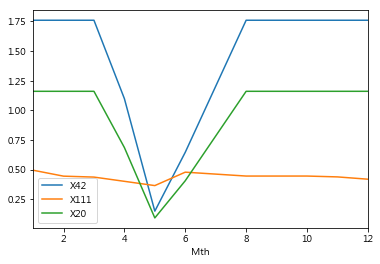

In [191]:
test_timevars.groupby('Mth')[rd_test1].mean().plot()

In [192]:
test_timevars.groupby('Mth')[rd_test2].mean().plot()

In [193]:
test_timevars.groupby('Mth')[rd_test3].mean().plot()

# 그래프그래프그으으으래래래ㅐㄹ프 그려라 

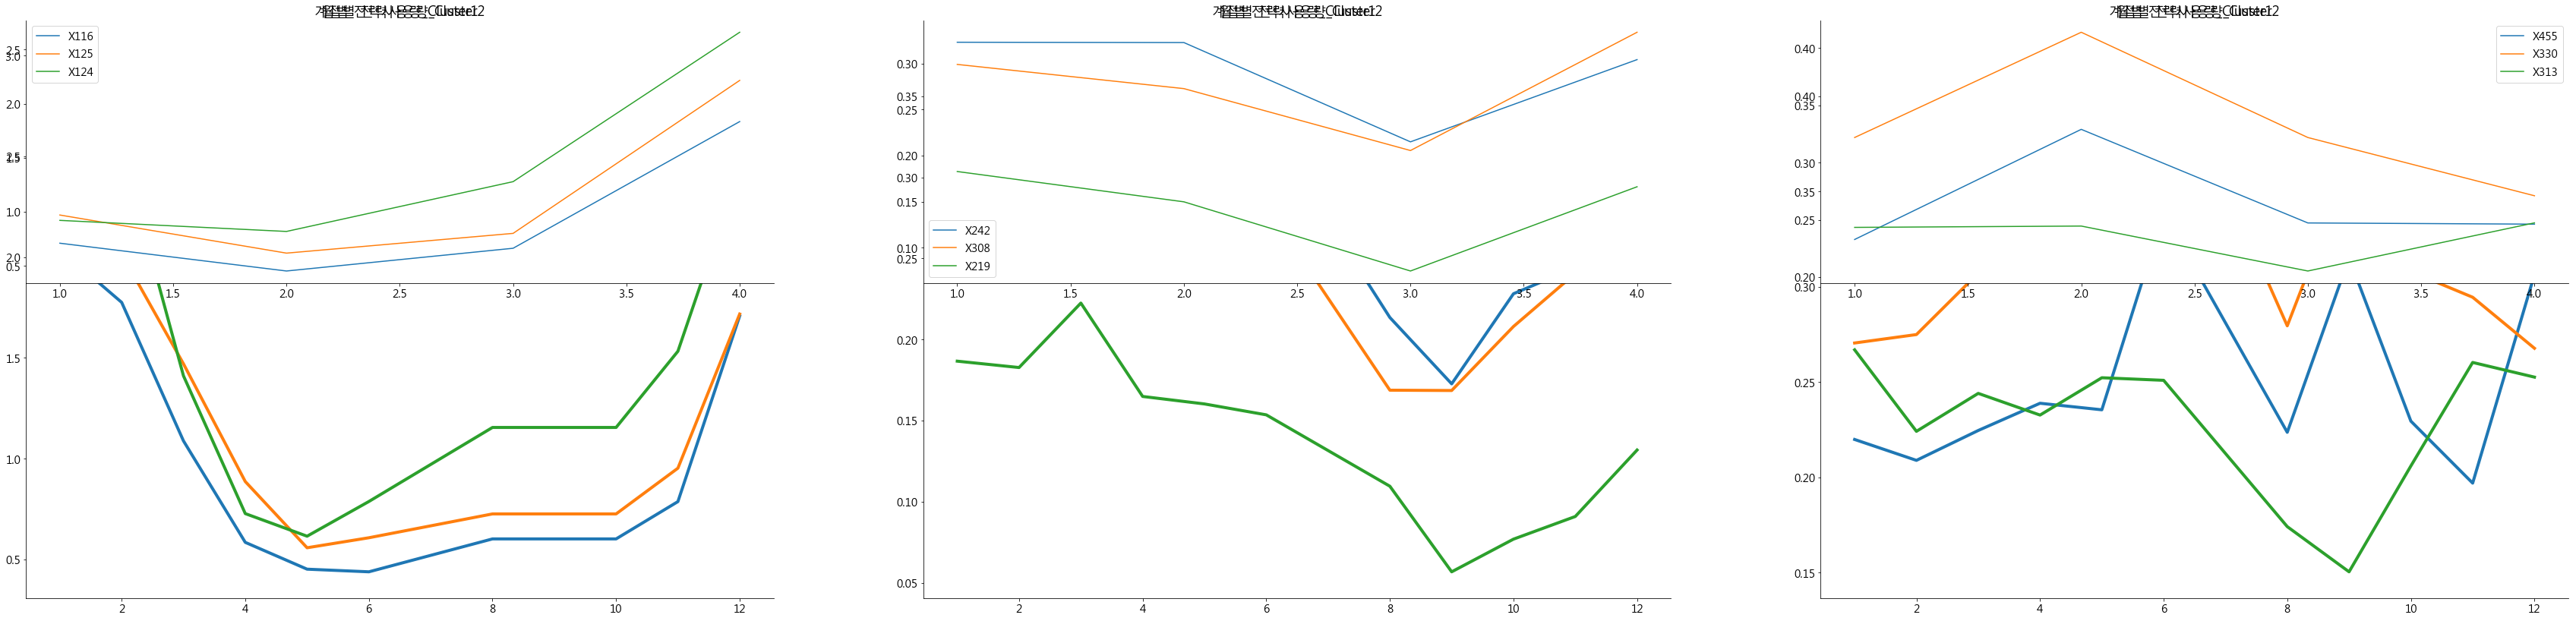

In [713]:
# plt.rcParams.update({'font.size': 15})
# fig = plt.figure(figsize=(60,14))
# clusters = [rd_test1, rd_test2, rd_test3]

# for i in range(1,3):
#     for k in range(1,4):
#         ax = fig.add_subplot(i,3,k)
#         ax.spines['top'].set_visible(False) ; ax.spines['right'].set_visible(False)
#         if i==1:
#             ax.set_title('월별 전력사용량_Cluster'+str(i))
#             ax.plot(test1.groupby('Mth')[clusters[k-1]].mean(), linewidth=4.0)  
#         else:
#             ax.set_title('계절별 전력사용량_Cluster'+str(i))
#             ax.plot(test1.groupby('season')[clusters[k-1]].mean())

#         ax.legend(clusters[k-1])

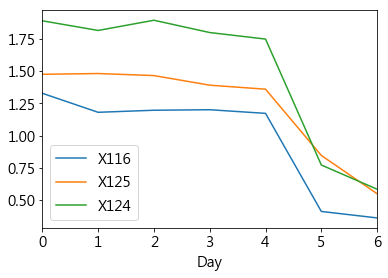

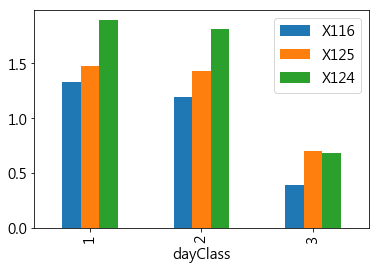

In [723]:
# test1.groupby('Day')[clusters[0]].mean().plot()
# test1.groupby('dayClass')[clusters[0]].mean().plot.bar()

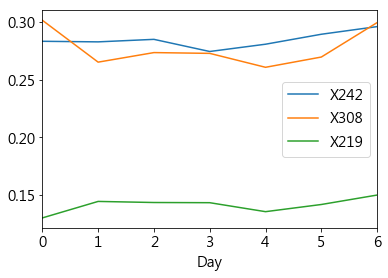

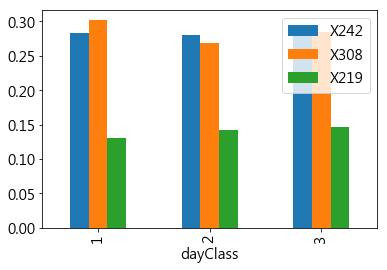

In [724]:
# test1.groupby('Day')[clusters[1]].mean().plot()
# test1.groupby('dayClass')[clusters[1]].mean().plot.bar()

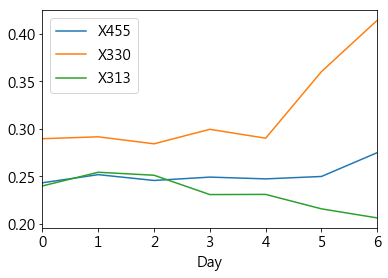

In [725]:
test1.groupby('Day')[clusters[2]].mean().plot()
test1.groupby('dayClass')[clusters[2]].mean().plot.bar()

In [199]:
test.head(2)

X26   X303   X241   X435   X402   X352   X305  \
Time                                                                      
2017-08-29 10:00:00  1.473264  0.431  0.276  0.228  0.432  0.232  0.348   
2017-08-29 11:00:00  1.473264  0.398  0.293  0.358  0.350  0.232  0.253   

                      X350   X326   X299  ...   X283   X329   X223      X266  \
Time                                      ...                                  
2017-08-29 10:00:00  0.259  0.194  0.086  ...  0.114  0.087  0.283  0.342026   
2017-08-29 11:00:00  0.260  0.168  0.084  ...  0.163  0.086  0.288  0.342026   

                          X20   X443   X347    X75   X107      X230  
Time                                                                 
2017-08-29 10:00:00  1.160255  0.094  0.351  1.109  0.225  0.296678  
2017-08-29 11:00:00  1.160255  0.196  0.343  1.109  0.225  0.296678  

[2 rows x 200 columns]

In [206]:
TE_time_vars.head(2)

Mth  Date  Day  hour  season  dayClass
Time                                                       
2017-08-29 10:00:00    8    29    1    10       2         2
2017-08-29 11:00:00    8    29    1    11       2         2

In [207]:
def dummies(df, dum_lst):
    df1 = df.copy()
    # dum_lst에 들어있는 각각의 변수마다 
    # tmp = get_dummies, 해당 original 변수는 drop
    # tmp와 변수가 drop된 df를 join 후 리턴
    for v in dum_lst:
        tmp = pd.get_dummies(df1[v], prefix=v)
        df1 = df1.drop(columns=v).join(tmp)
    return df1

In [209]:
TE_timeV_dum = dummies(TE_time_vars, ['season', 'dayClass'])

In [210]:
TE_timeV_dum.head()

Mth  Date  Day  hour  season_1  season_2  season_3  \
Time                                                                      
2017-08-29 10:00:00    8    29    1    10         0         1         0   
2017-08-29 11:00:00    8    29    1    11         0         1         0   
2017-08-29 12:00:00    8    29    1    12         0         1         0   
2017-08-29 13:00:00    8    29    1    13         0         1         0   
2017-08-29 14:00:00    8    29    1    14         0         1         0   

                     season_4  dayClass_1  dayClass_2  dayClass_3  
Time                                                               
2017-08-29 10:00:00         0           0           1           0  
2017-08-29 11:00:00         0           0           1           0  
2017-08-29 12:00:00         0           0           1           0  
2017-08-29 13:00:00         0           0           1           0  
2017-08-29 14:00:00         0           0           1           0

# Modeling

* test : TEST셋의 순수한 meterIDs Time series (NA값 채워짐) 
* TE_timeV_dum: TEST셋의 시간파생변수 + dummy variables 

In [211]:
test.head(1)

X26   X303   X241   X435   X402   X352   X305  \
Time                                                                      
2017-08-29 10:00:00  1.473264  0.431  0.276  0.228  0.432  0.232  0.348   

                      X350   X326   X299  ...   X283   X329   X223      X266  \
Time                                      ...                                  
2017-08-29 10:00:00  0.259  0.194  0.086  ...  0.114  0.087  0.283  0.342026   

                          X20   X443   X347    X75   X107      X230  
Time                                                                 
2017-08-29 10:00:00  1.160255  0.094  0.351  1.109  0.225  0.296678  

[1 rows x 200 columns]

In [212]:
TE_timeV_dum.head(1)

Mth  Date  Day  hour  season_1  season_2  season_3  \
Time                                                                      
2017-08-29 10:00:00    8    29    1    10         0         1         0   

                     season_4  dayClass_1  dayClass_2  dayClass_3  
Time                                                               
2017-08-29 10:00:00         0           0           1           0

In [216]:
data = pd.concat([pd.DataFrame(test.X303), TE_timeV_dum], axis=1)
data = data.rename(columns={'X303':'y'})

for i in [24, 168]:
    data['lag_{}'.format(i)] = data.y.shift(i)

In [218]:
data.head(2)

y  Mth  Date  Day  hour  season_1  season_2  \
Time                                                                   
2017-08-29 10:00:00  0.431    8    29    1    10         0         1   
2017-08-29 11:00:00  0.398    8    29    1    11         0         1   

                     season_3  season_4  dayClass_1  dayClass_2  dayClass_3  \
Time                                                                          
2017-08-29 10:00:00         0         0           0           1           0   
2017-08-29 11:00:00         0         0           0           1           0   

                     lag_24  lag_168  
Time                                  
2017-08-29 10:00:00     NaN      NaN  
2017-08-29 11:00:00     NaN      NaN

In [291]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

In [219]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def timeseries_splitn(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [221]:
# def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False, scale=1.96):
#     """
#         Plots modelled vs fact values, prediction intervals and anomalies
    
#     """
#     prediction = model.predict(X_test)
    
#     plt.figure(figsize=(15, 7))
#     plt.plot(prediction, "g", label="prediction", linewidth=2.0)
#     plt.plot(y_test.values, label="actual", linewidth=2.0)
    
#     if plot_intervals:
#         cv = cross_val_score(model, X_train, y_train, 
#                                     cv=tscv, 
#                                     scoring="neg_mean_squared_error")
#         #mae = cv.mean() * (-1)
#         deviation = np.sqrt(cv.std())
        
#         lower = prediction - (scale * deviation)
#         upper = prediction + (scale * deviation)
        
#         plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
#         plt.plot(upper, "r--", alpha=0.5)
        
#         if plot_anomalies:
#             anomalies = np.array([np.NaN]*len(y_test))
#             anomalies[y_test<lower] = y_test[y_test<lower]
#             anomalies[y_test>upper] = y_test[y_test>upper]
#             plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
#     error = mean_absolute_percentage_error(prediction, y_test)
#     plt.title("Mean absolute percentage error {0:.2f}%".format(error))
#     plt.legend(loc="best")
#     plt.tight_layout()
#     plt.grid(True);
    
# def plotCoefficients(model):
#     """
#         Plots sorted coefficient values of the model
#     """
    
#     coefs = pd.DataFrame(model.coef_, X_train.columns)
#     coefs.columns = ["coef"]
#     coefs["abs"] = coefs.coef.apply(np.abs)
#     coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
#     plt.figure(figsize=(15, 7))
#     coefs.coef.plot(kind='bar')
#     plt.grid(True, axis='y')
#     plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
    

In [295]:
from SMAPE import smape_fast
from sklearn.preprocessing import StandardScaler

In [304]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

def model_Validation (X, y,size, model):
    model = model

    # reserve 30% of data for testing
    X_train, X_valid, y_train, y_valid = timeseries_train_test_split(X, y, test_size=size)
    
    valid_time = X_valid.index
    X_train = sc.fit_transform(X_train)
    X_valid = sc.transform(X_valid)   

    model.fit(X_train, y_train)
    
    pred = model.predict(X_valid)
    error = smape_fast(pred, y_valid)
    print('SMAPE:',error)
    return X_train, X_valid, y_train, y_valid, valid_time, pred

In [305]:
data.head(1)

y  Mth  Date  Day  hour  season_1  season_2  \
Time                                                                   
2017-08-29 10:00:00  0.431    8    29    1    10         0         1   

                     season_3  season_4  dayClass_1  dayClass_2  dayClass_3  \
Time                                                                          
2017-08-29 10:00:00         0         0           0           1           0   

                     lag_24  lag_168  
Time                                  
2017-08-29 10:00:00     NaN      NaN

In [306]:
_,_,_,y_valid,valid_time, pred_X303_LR = model_Validation(X,y, 0.3, LinearRegression())

SMAPE: 89.78890815640966


In [308]:
from sklearn.linear_model import LassoCV, RidgeCV

In [309]:
_,_,_,y_valid,valid_time, pred_X303_Ridge = model_Validation(X,y, 0.3, RidgeCV(cv=tscv))

SMAPE: 40.00173845494072


In [310]:
_,_,_,y_valid,valid_time,  pred_X303_Lasso = model_Validation(X,y, 0.3, LassoCV(cv=tscv))

SMAPE: 40.74235355064452


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



SMAPE: 39.22014402174727


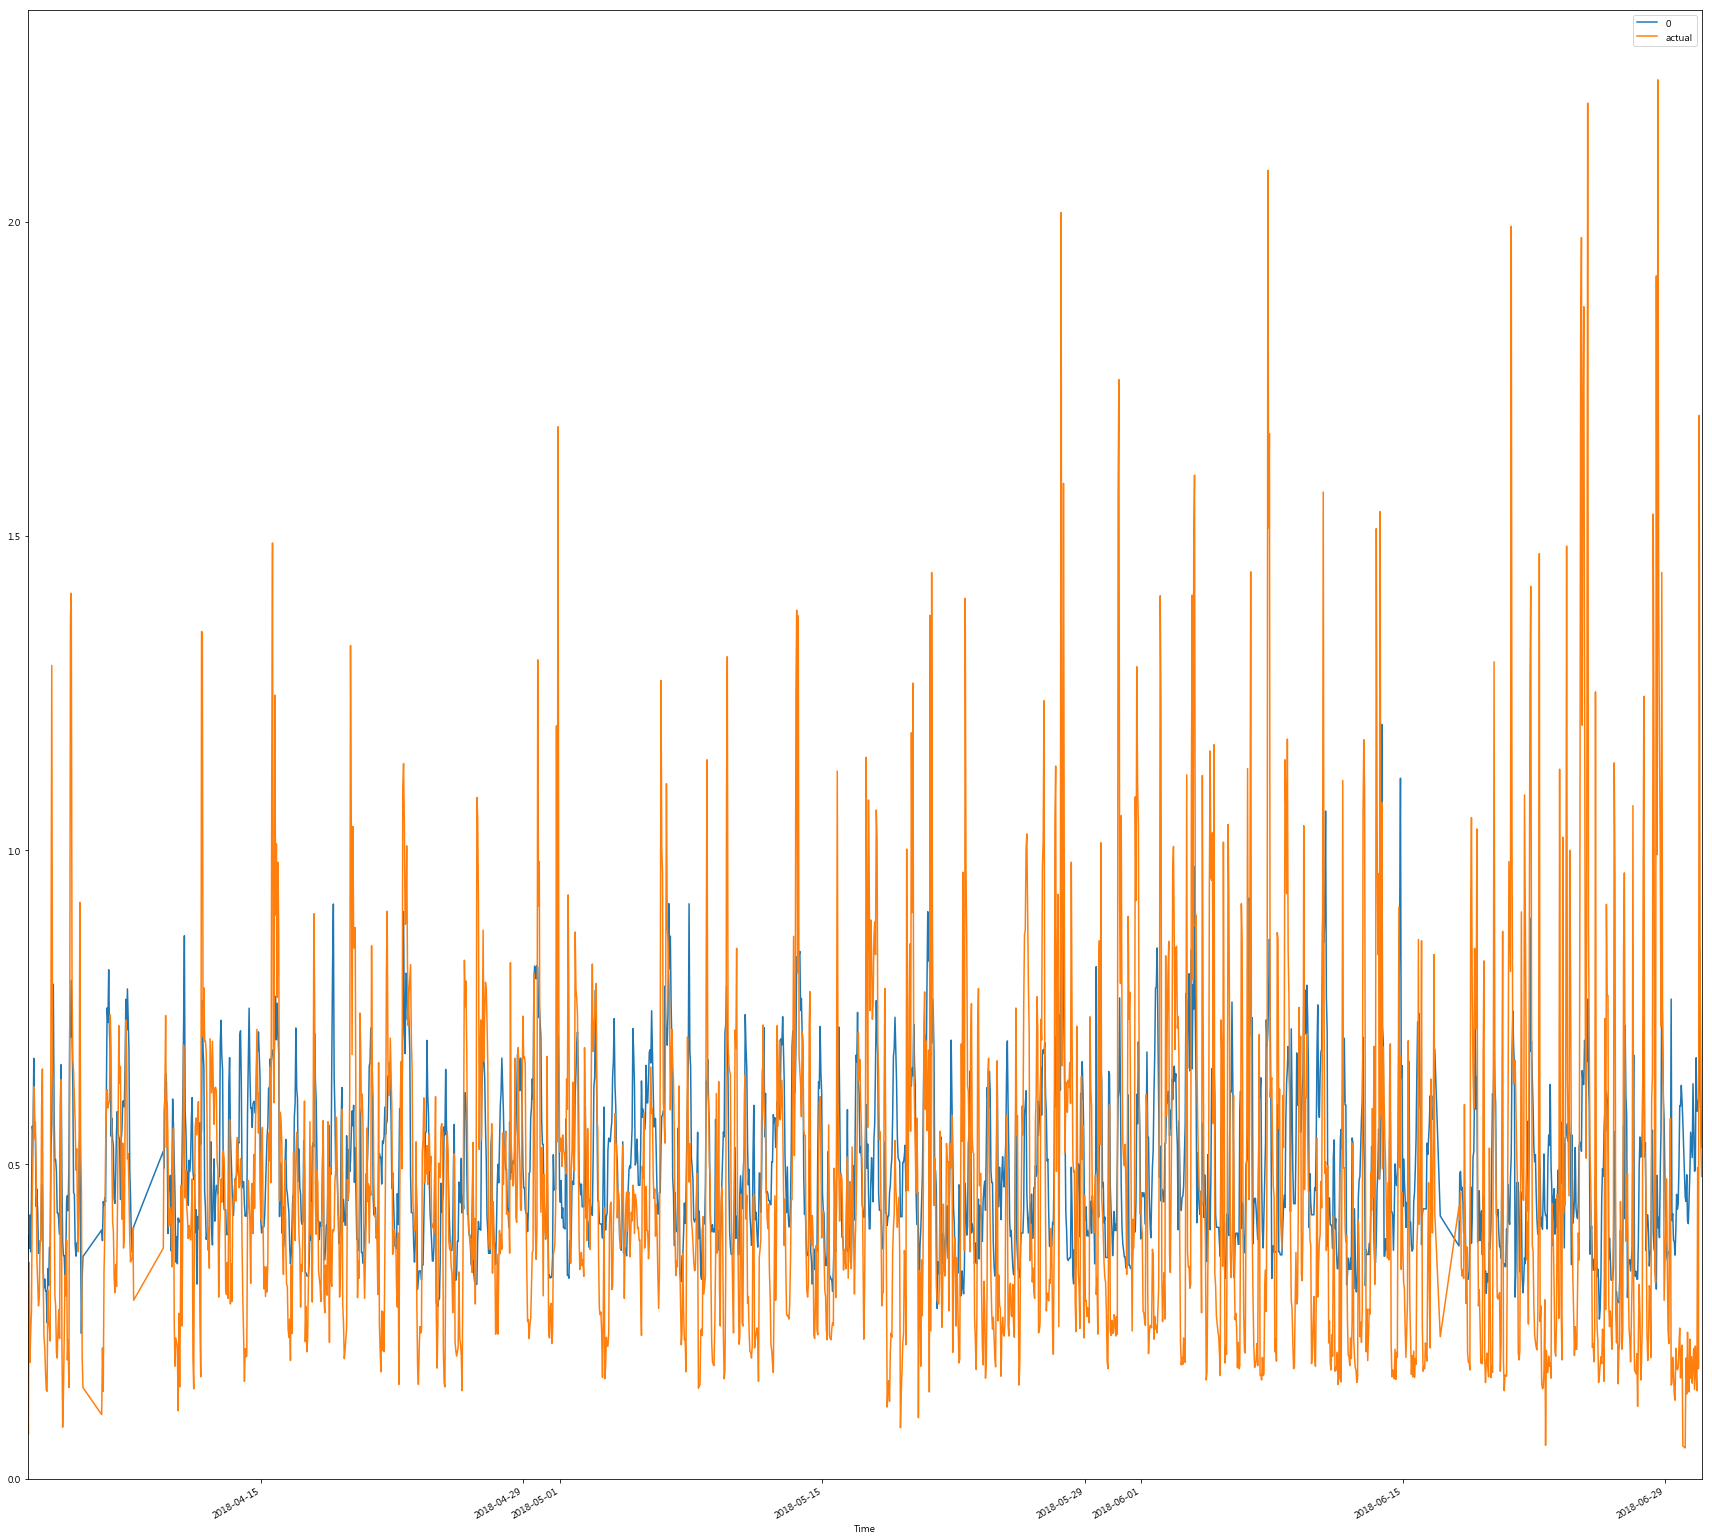

In [411]:
from xgboost import XGBRegressor 
xgb = XGBRegressor(verbosity=0)
_,_,_,y_valid,valid_time, pred_X303_XG = model_Validation(X,y, 0.3, xgb)

df = pd.DataFrame(pred_X303_XG, index = valid_time)
df['actual'] = y_valid
df.plot(figsize = (30,30))

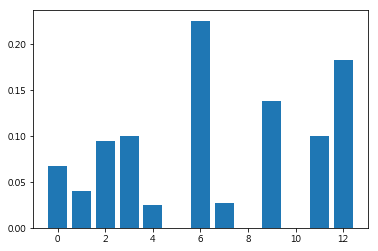

In [413]:
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.show()

In [317]:
from lightgbm import LGBMRegressor
lgb = LGBMRegressor()
_,_,_,y_valid,valid_time, pred_X303_LGB = model_Validation(X,y, 0.3, lgb)

df = pd.DataFrame(pred_X303_LGB, index = valid_time)
df['actual'] = y_valid
df.plot(figsize = (30,30))

SMAPE: 38.142766315359786


SMAPE: 40.95945558899968


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



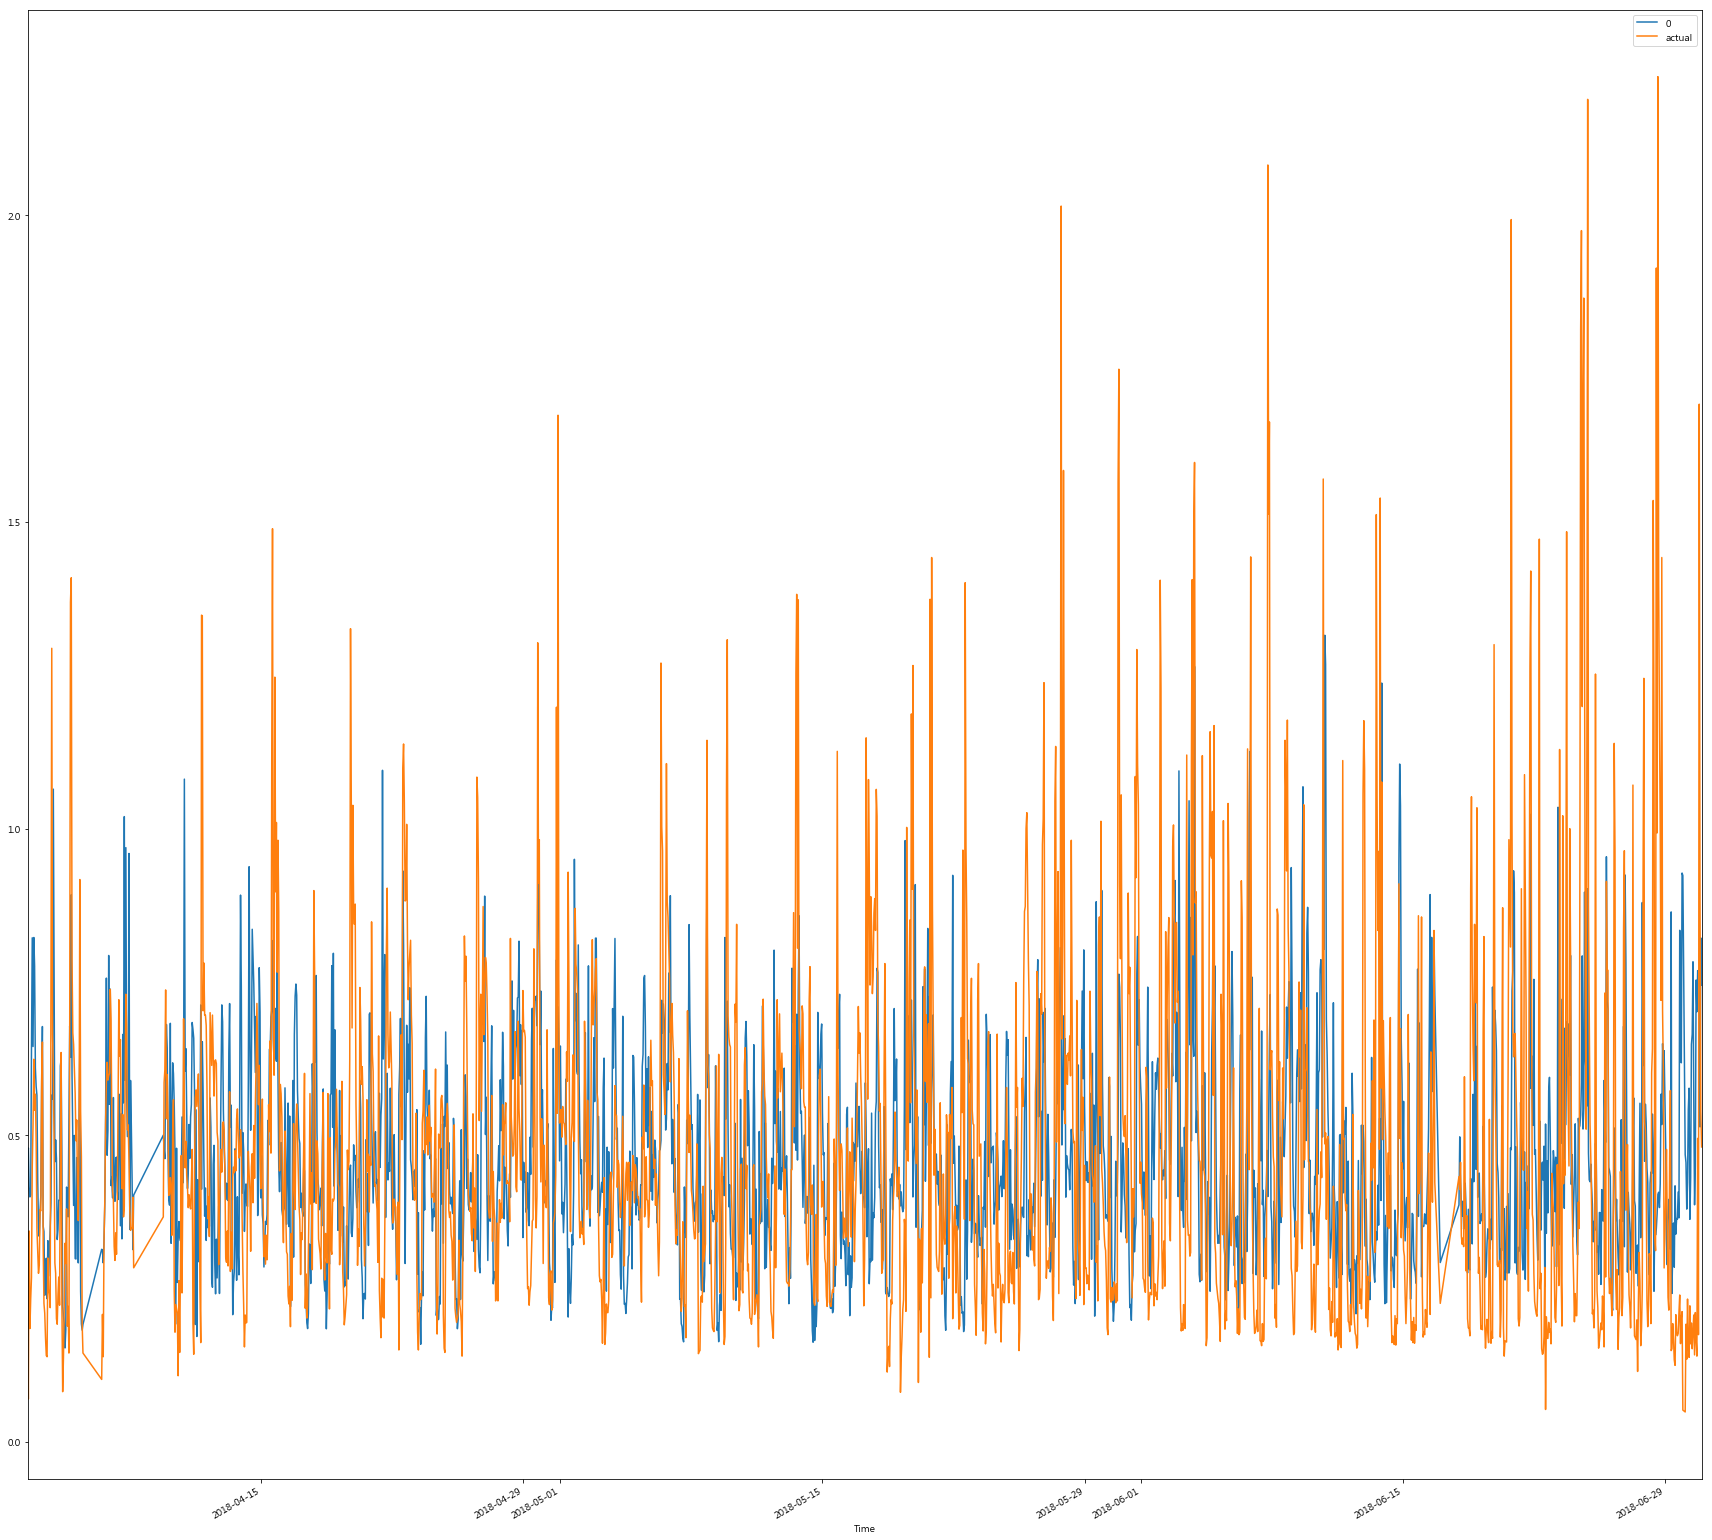

In [318]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
_,_,_,y_valid,valid_time, pred_X303_RF = model_Validation(X,y, 0.3, rf)

df = pd.DataFrame(pred_X303_RF, index = valid_time)
df['actual'] = y_valid
df.plot(figsize = (30,30))

In [ ]:
from sklearn.model_selection import GridSearchCV
XGparams = 

TypeError: invalid type promotion